In [128]:
import pandas as pd
import numpy as np
from forex_python.converter import CurrencyRates
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from bubble_plot.bubble_plot import bubble_plot

In [129]:
# Read file
file = pd.read_csv('stack-overflow-developer-survey-2021/survey_results_public.csv') 

In [130]:
# years of experience
yoe = file[["ResponseId","YearsCodePro","ConvertedCompYearly","Currency",'CompTotal', 'CompFreq']]

In [131]:
# Set "prefer not to say" to NaN and drop
yoe=yoe.replace("Prefer not to say",np.NaN)
yoe=yoe.replace("Less than 1 year",0.5)
yoe=yoe.replace("More than 50 years",np.NaN)
yoe=yoe.dropna()

In [132]:
def removeOutliers(df, col_name):
        """
        This method removes outliers which based on q1 - (1.5 * IQR) and
        q3 - (1.5 * IQR)
        :param df: [pd.DataFrame] Input Dataframe
        :param col_name: [str] Column name whose outliers are to be removed
        :return: [pd.DataFrame] Dataframe with outliers removed
        """
        assert isinstance(df, pd.DataFrame), "Input has to be a pandas dataframe"
        assert isinstance(col_name, str), f"{col_name} has to be a string"
        assert col_name in list(df.columns.values), f"{col_name} is not a column in the dataframe"
        sorted_vals = df[col_name].sort_values()
        q1 = np.percentile(sorted_vals, 25)
        q3 = np.percentile(sorted_vals, 75)
        IQR = q3 - q1
        lwr_bound = q1 - (1.5 * IQR)
        upr_bound = q3 + (1.5 * IQR)
        df = df[(((df[col_name] < lwr_bound) | (df[col_name] > upr_bound)) == False)]
        return df

def wrangleComp(df):
    """
    This method
    :param df:[pd.DataFrame] Input Dataframe
    :return: [pd.DataFrame] Output Dataframe with wrangled columns
    """
    assert isinstance(df, pd.DataFrame), "Input has to be a pandas dataframe"
    assert all(x in df.columns.values for x in ['CompTotal', 'Currency', 'CompFreq'])
    df_comp = df.dropna(subset=['CompTotal'])
    # extracting currency symbol from 'Currency' column
    df_comp['curr_symbol'] = df_comp['Currency'].str[:3]

    # keeping only USD
    df_comp = df_comp[df_comp['curr_symbol'].isin(['USD'])]
    df_comp['abs_comp'] = df_comp['CompTotal'].copy()

    # adjusting CompTotal according to frequency
    df_comp['abs_comp'] = np.where(df_comp['CompFreq'] == 'Weekly',
                                   df_comp['CompTotal'] * 52,
                                   df_comp['abs_comp'])
    df_comp['abs_comp'] = np.where(df_comp['CompFreq'] == 'Monthly',
                                   df_comp['CompTotal'] * 12,
                                   df_comp['abs_comp'])
    # Converting compensation into thousands
    df_comp['abs_comp_k'] = df_comp['abs_comp'] / 1000
    df_comp = removeOutliers(df_comp, 'abs_comp_k')
    return df_comp

In [133]:
yoe = wrangleComp(yoe)

In [134]:
yoe

,ResponseId,YearsCodePro,ConvertedCompYearly,Currency,CompTotal,CompFreq,curr_symbol,abs_comp,abs_comp_k
34,35,10,24000.0,USD\tUnited States dollar,2000.0,Monthly,USD,24000.0,24.0
36,37,0.5,103000.0,USD\tUnited States dollar,103000.0,Yearly,USD,103000.0,103.0
62,63,5,130000.0,USD\tUnited States dollar,130000.0,Yearly,USD,130000.0,130.0
75,76,15,105000.0,USD\tUnited States dollar,105000.0,Yearly,USD,105000.0,105.0
87,88,1,100000.0,USD\tUnited States dollar,100000.0,Yearly,USD,100000.0,100.0
...,...,...,...,...,...,...,...,...,...
83422,83423,18,20000.0,USD\tUnited States dollar,20000.0,Yearly,USD,20000.0,20.0
83423,83424,5,25000.0,USD\tUnited States dollar,500.0,Weekly,USD,26000.0,26.0
83430,83431,21,125000.0,USD\tUnited States dollar,125000.0,Yearly,USD,125000.0,125.0
83434,83435,5,160500.0,USD\tUnited States dollar,160500.0,Yearly,USD,160500.0,160.5


In [135]:
# yoe['salary_USD'] = yoe.apply( lambda x: conversion2usd(x.ConvertedCompYearly,x.Currency), axis = 1)
yoe['YearsCodePro'] = pd.to_numeric(yoe['YearsCodePro'])

### Years of Experience - Compensation in the US

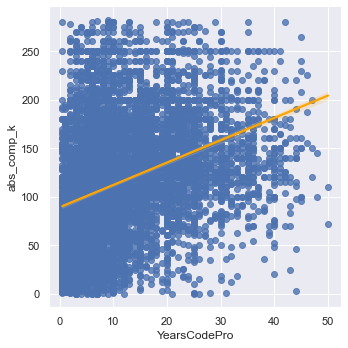

In [147]:
# # convert salary into k USD
# yoe['salary_USD_K'] = yoe['salary_USD'] /1000
# # get rid of outliers
# yoe = yoe[yoe['salary_USD_K'] <=500]
# show bubble plot
sns.set(rc = {'figure.figsize':(15,8)})
# sns.scatterplot(y='salary_USD_K', x='YearsCodePro', data=yoe, size='YearsCodePro', legend=False, sizes=(20, 200))
sns.lmplot(y='abs_comp_k', x='YearsCodePro', data=yoe, line_kws={'color': 'orange'})
plt.show()

In [137]:
location= file[["ResponseId", "Country","ConvertedCompYearly","Currency",'CompTotal', 'CompFreq']]
us_states = file[["ResponseId", "US_State","ConvertedCompYearly","Currency",'CompTotal', 'CompFreq']]
location=location.replace("Prefer not to say",np.NaN)
us_states = us_states.replace("Prefer not to say",np.NaN)


location=location.dropna()
us_states = us_states.dropna()


location = wrangleComp(location)
us_states = wrangleComp(us_states)

### European countries - Compensation

In [138]:
# location = location[location['Currency'] == 'EUR']
euro_country = location[location['Country'].isin([ 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
  'Italy', 'Luxembourg', 'Malta', 'Netherlands',
  'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden'])]
#'Austria',, 'Latvia', 'Lithuania', 'Denmark','Estonia'

In [139]:
euro_country

,ResponseId,Country,ConvertedCompYearly,Currency,CompTotal,CompFreq,curr_symbol,abs_comp,abs_comp_k
1066,1067,Croatia,75000.0,USD\tUnited States dollar,75000.0,Yearly,USD,75000.0,75.000
1096,1097,Poland,55200.0,USD\tUnited States dollar,4600.0,Monthly,USD,55200.0,55.200
1556,1557,Hungary,120000.0,USD\tUnited States dollar,120000.0,Yearly,USD,120000.0,120.000
1887,1888,Germany,165000.0,USD\tUnited States dollar,165000.0,Yearly,USD,165000.0,165.000
2189,2190,Croatia,140000.0,USD\tUnited States dollar,140000.0,Yearly,USD,140000.0,140.000
...,...,...,...,...,...,...,...,...,...
79843,79844,Netherlands,173000.0,USD\tUnited States dollar,173000.0,Yearly,USD,173000.0,173.000
80097,80098,Croatia,80000.0,USD\tUnited States dollar,1600.0,Weekly,USD,83200.0,83.200
80825,80826,Poland,110000.0,USD\tUnited States dollar,110000.0,Yearly,USD,110000.0,110.000
81221,81222,Spain,54564.0,USD\tUnited States dollar,54564.0,Yearly,USD,54564.0,54.564


[Text(0, 0, 'Croatia'),
 Text(1, 0, 'Poland'),
 Text(2, 0, 'Hungary'),
 Text(3, 0, 'Germany'),
 Text(4, 0, 'France'),
 Text(5, 0, 'Romania'),
 Text(6, 0, 'Ireland'),
 Text(7, 0, 'Spain'),
 Text(8, 0, 'Netherlands'),
 Text(9, 0, 'Bulgaria'),
 Text(10, 0, 'Greece'),
 Text(11, 0, 'Italy'),
 Text(12, 0, 'Portugal'),
 Text(13, 0, 'Sweden')]

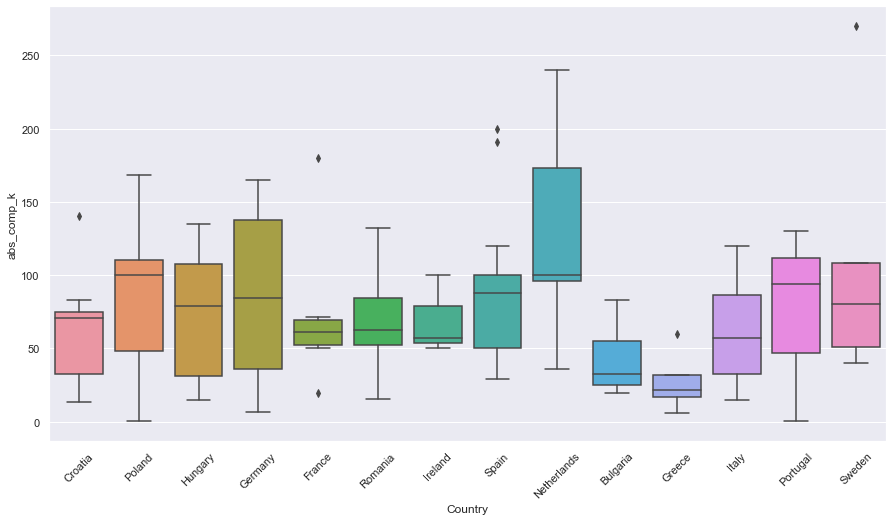

In [140]:
# show plot
# euro_country['salary_USD_K'] = euro_country['salary_USD'] /1000
# euro_country = euro_country[euro_country['salary_USD_K'] <=200]
plt.figure(figsize=(15,8))
ax = sns.boxplot(x = 'Country', y = 'abs_comp_k', data = euro_country)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

### States in the US - Compensation

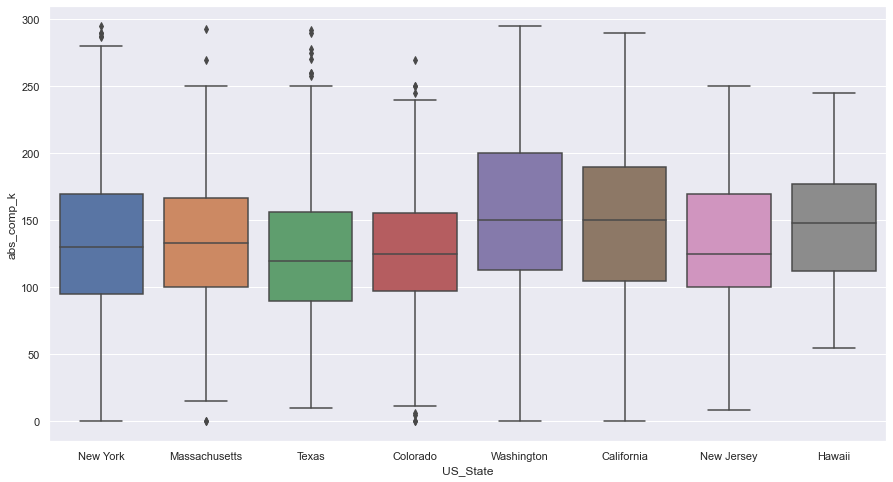

In [141]:
# us_states = us_states[us_states['Currency'] == 'USD']
# us_states['salary_USD_K'] = us_states['salary_USD'] /1000
us_states = us_states[us_states['US_State'].isin(['Washington', 'California', 'New Jersey', 'New York', 'Massachusetts', 'Texas', 'Colorado', 'Hawaii'])]
# us_states = us_states[us_states['salary_USD_K'] <=500]

plt.figure(figsize=(15,8))
ax = sns.boxplot(x = 'US_State', y = 'abs_comp_k', data = us_states)
# ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [142]:
import patsy
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats


outcome, predictors = patsy.dmatrices('abs_comp_k ~ YearsCodePro', yoe)
model = sm.OLS(outcome, predictors)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             abs_comp_k   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     1584.
Date:                Fri, 26 Nov 2021   Prob (F-statistic):          3.95e-323
Time:                        22:06:23   Log-Likelihood:                -57948.
No. Observations:               10712   AIC:                         1.159e+05
Df Residuals:                   10710   BIC:                         1.159e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       89.0506      0.805    110.631   

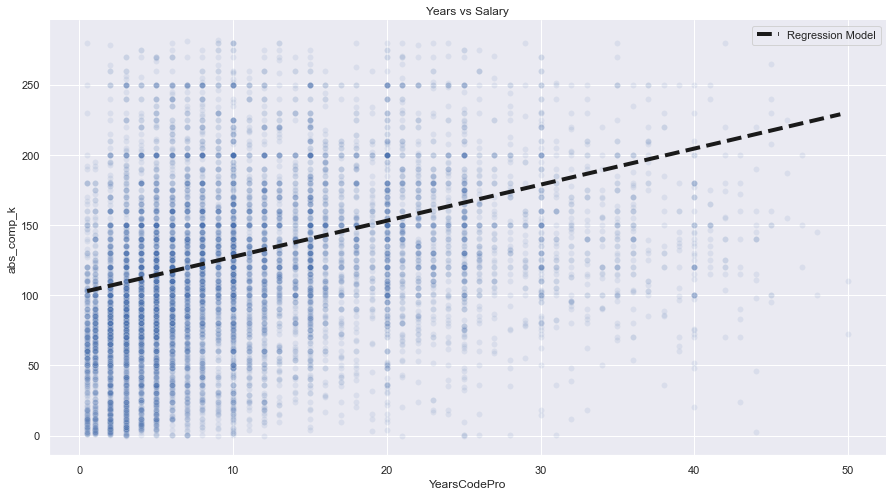

In [143]:
# Plot original graph

plot1 = sns.scatterplot(alpha=0.1, x='YearsCodePro', y='abs_comp_k', data=yoe)
plot1.set(title='Years vs Salary', xlabel = 'YearsCodePro', ylabel='abs_comp_k')
sns.despine();

# Generate and plot the model fit line
xs = np.arange(yoe['YearsCodePro'].min(), yoe['YearsCodePro'].max()) # Range
ys = 2.5715*xs + 101.6436 # Retrieved from OLS regression results
plt.plot(xs, ys, '--k', linewidth=4, label='Regression Model')
plt.legend();
plt.savefig("regression.png")